In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

# TEST ADF NA STACJONARNOSC

In [4]:
def adf_test(x, alpha=0.05):
    p_val = []
    is_stationary = []
    trend = ['Stała', 'Linia', 'Parabola', 'Brak']
    trends = ['c', 'ct', 'ctt', 'n']

    for i in trends:
        result = adfuller(x, regression=i, autolag='AIC')
        p = result[1]
        p_val.append(p)
        if p < alpha:
            is_stationary.append('Tak')
        else:
            is_stationary.append('Nie')

    return pd.DataFrame({
        'Trend': trend,
        'P-value': p_val,
        f'Stacjonarny (α={alpha})': is_stationary
        })

# TESTY NA NORMALNOŚĆ

In [5]:
def normality_tests(data):
    # Parametry dla rozkładu normalnego
    loc, sc = st.norm.fit(data)

    # Test Kolmogorova-Smirnova
    ks_result = st.kstest(data, 'norm', args=(loc, sc))
    ks_stat, ks_p_value = ks_result.statistic, ks_result.pvalue
    
    # Test normalności (D'Agostino i Pearson)
    normaltest_stat, normaltest_p_value = st.normaltest(data)

    # Test Shapiro-Wilka
    shapiro_stat, shapiro_p_value = st.shapiro(data)
    print(shapiro_stat,shapiro_p_value)
    
    # Interpretacja wyników
    print("Test Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu normalnego.")
    
    print("\nTest D'Agostino i Pearson:")
    print(f"Statystyka: {normaltest_stat:.4f}, p-wartość: {normaltest_p_value:.4f}")
    print("Wynik testu D'Agostino i Pearson:")
    if normaltest_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")
    
    print("\nTest Shapiro-Wilka:")
    print(f"Statystyka: {shapiro_stat:.4f}, p-wartość: {shapiro_p_value:.4f}")
    print("Wynik testu Shapiro-Wilka:")
    if shapiro_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą być normalnie rozłożone.")



# TEST NA ROZKLAD T - STUDENTA

In [6]:
def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")

# FUNKCJA DO PARAMETRÓW - MIAR RYZYKA

In [7]:
def parametry(X):
    '''funkcja zwraca tabele z wynikami'''
    # główne parametry
    mean = np.mean(X)
    n = len(X)
    
    # odchylenie standardow
    std = np.std(X)
    # odchylenie przeciętne
    przec_std = np.sum(np.abs(X - mean)) / (n-1)
    
    # rozstęp międzykwartylowy
    q = np.quantile(X, [0.25, 0.75])
    rozstep = q[0]-q[1]

    # odchylenie ćwiartkowe
    cwiartk = (q[1] - q[0]) / 2
    
    # semiodchylenie standardowe
    semi_std = np.sqrt(np.sum(X[X -mean>0] ** 2) / (n-1) )
    # semidochylenie przeciętne
    semi_przec = np.sum(np.abs(X[X -mean>0] - mean)) / (n-1)

    # współczynnik zmienności
    zmiennosc = std/mean

    nazwy = ['Odchylenie standardowe', 'Odchylenie przeciętne', 'Rozstęp międzykwartylowy', 'Odchylenie ćwiartkowe', 
             'Semiodchylenie standardowe', 'Semiodchylenie przeciętne', 'Średnia', 'Współczynnik zmienności']
    wartosci = [std, przec_std, rozstep, cwiartk, semi_std, semi_przec, mean, zmiennosc]
    data = pd.DataFrame({'Miara':nazwy, 'Wartość':wartosci})
    return data

N = 100000

# KURS AKCJI TSMC (daily)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


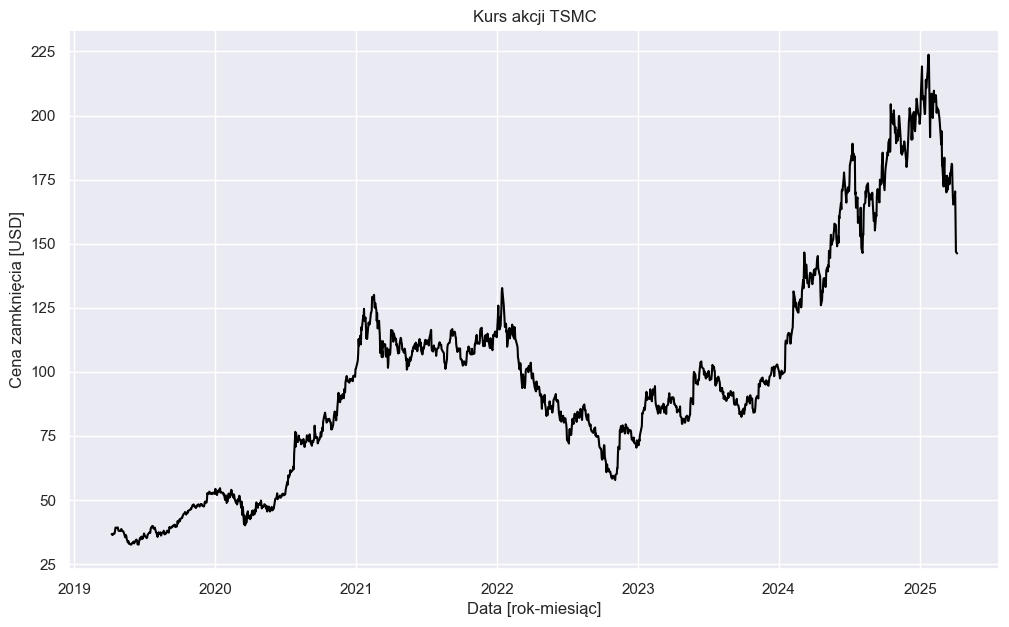

In [8]:
tsmc_data = yf.download('TSM', period = '6y')
tsmc_data = tsmc_data['Close']

plt.plot(tsmc_data, color = 'black')
plt.title('Kurs akcji TSMC')
plt.ylabel('Cena zamknięcia [USD]')
plt.xlabel('Data [rok-miesiąc]')
plt.grid(True)
plt.show()

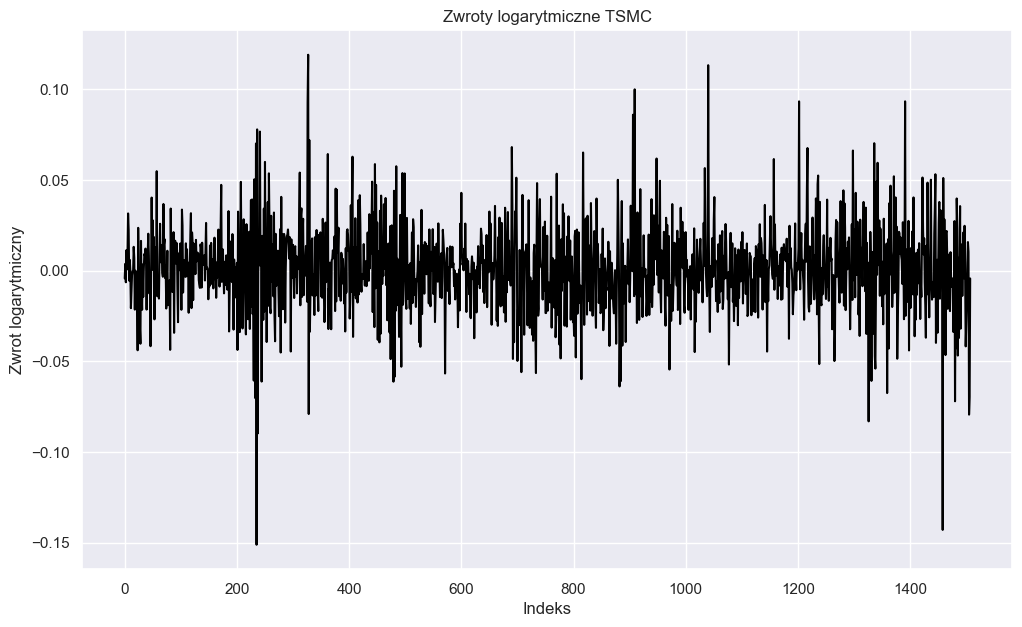

In [9]:
log_returns_tsmc = np.log(tsmc_data / tsmc_data.shift(1)).dropna()
log_returns_tsmc = np.ravel(log_returns_tsmc)

plt.plot(log_returns_tsmc, color = 'black')
plt.title('Zwroty logarytmiczne TSMC')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()


In [10]:
adf_results = adf_test(log_returns_tsmc)
print(adf_results)

      Trend  P-value Stacjonarny (α=0.05)
0     Stała   0.0000                  Tak
1     Linia   0.0000                  Tak
2  Parabola   0.0000                  Tak
3      Brak   0.0000                  Tak


____
# MIEDŹ

[*********************100%***********************]  1 of 1 completed


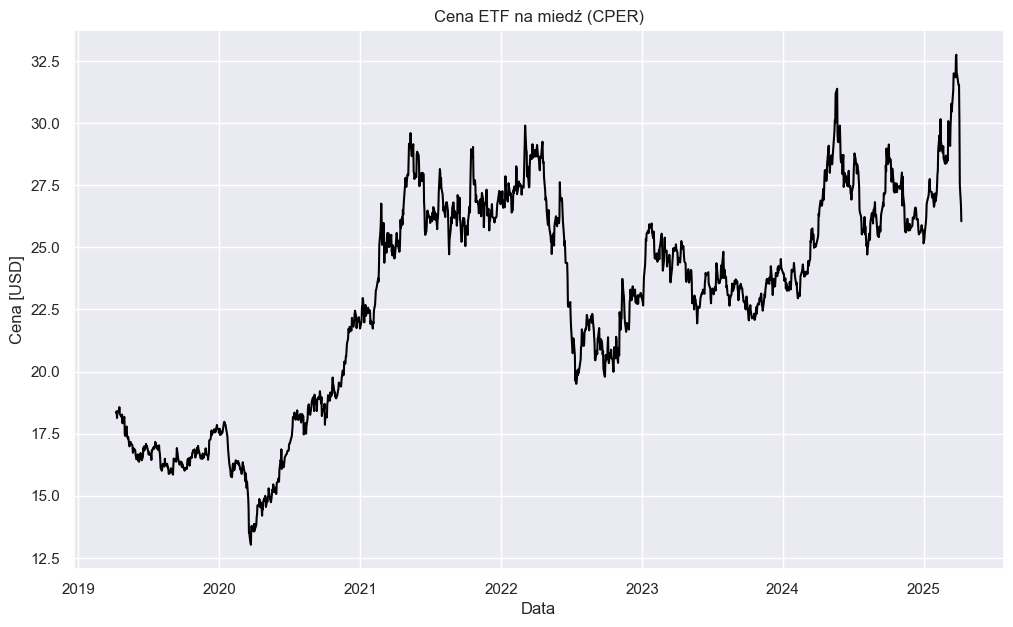

In [11]:
copper = yf.download('CPER', period='6y')['Close']

plt.plot(copper, color = 'black')
plt.title('Cena ETF na miedź (CPER)')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

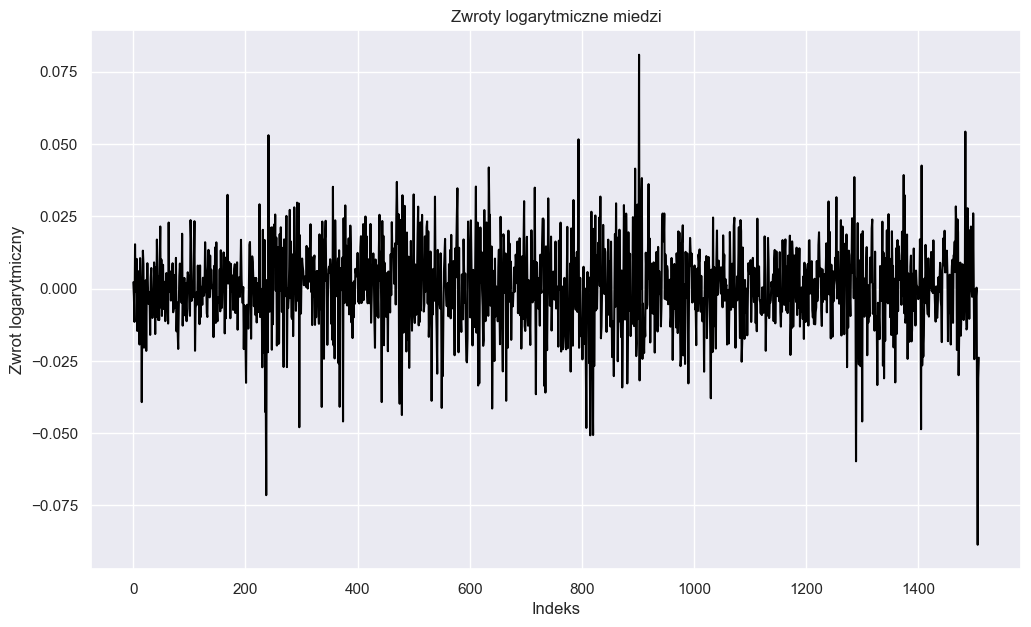

In [12]:
log_returns_copper = np.log(copper / copper.shift(1)).dropna()
log_returns_copper = np.ravel(log_returns_copper)
plt.plot(log_returns_copper, color = 'black')
plt.title('Zwroty logarytmiczne miedzi')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()


In [13]:
print(adf_test(log_returns_copper))

      Trend  P-value Stacjonarny (α=0.05)
0     Stała   0.0000                  Tak
1     Linia   0.0000                  Tak
2  Parabola   0.0000                  Tak
3      Brak   0.0000                  Tak


___ 
# Kurs akcji Samsung Electronics

[*********************100%***********************]  1 of 1 completed


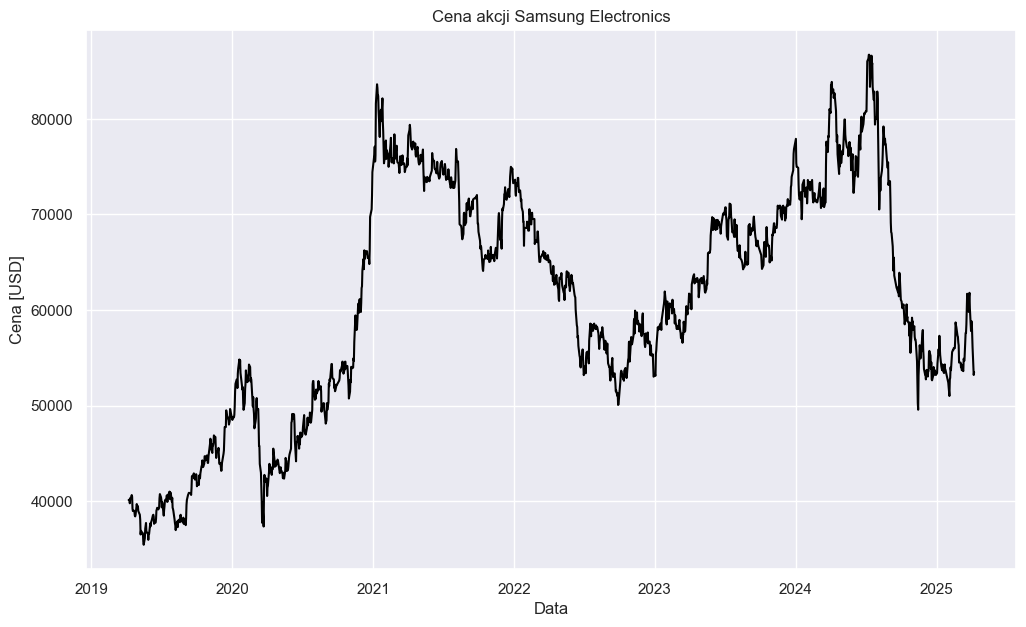

In [14]:
samsung = yf.download('005930.KS', period='6y')['Close']

plt.plot(samsung, color = 'black')
plt.title('Cena akcji Samsung Electronics')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()


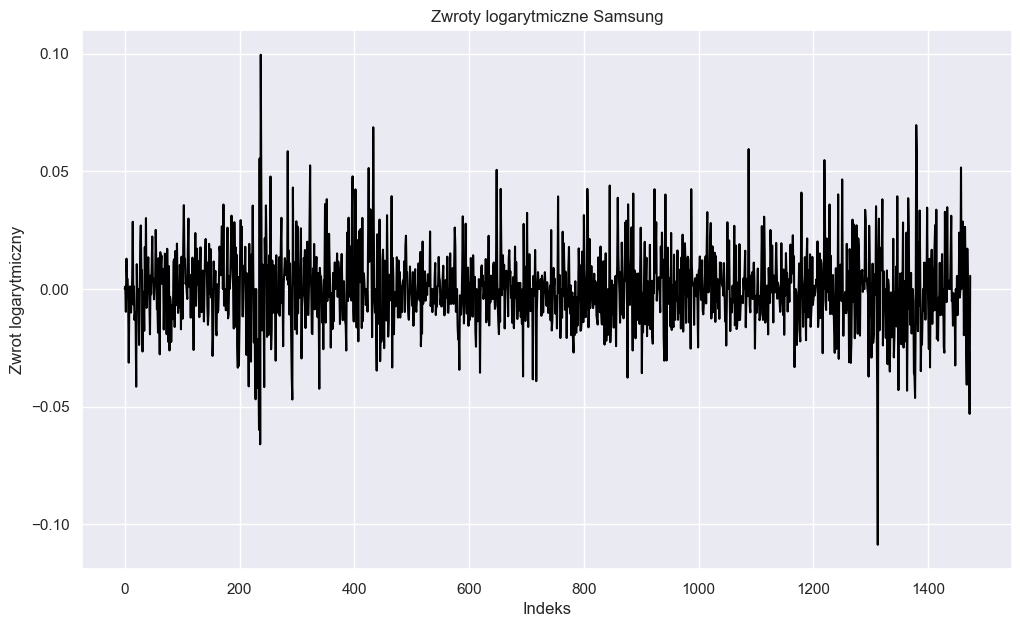

In [15]:
log_returns_samsung = np.log(samsung / samsung.shift(1)).dropna()
log_returns_samsung = np.ravel(log_returns_samsung)
plt.plot(log_returns_samsung, color = 'black')
plt.title('Zwroty logarytmiczne Samsung')
plt.ylabel('Zwrot logarytmiczny')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

In [16]:
print(adf_test(log_returns_samsung))

      Trend  P-value Stacjonarny (α=0.05)
0     Stała   0.0000                  Tak
1     Linia   0.0000                  Tak
2  Parabola   0.0000                  Tak
3      Brak   0.0000                  Tak


____ 
# Analiza jednowymiarowa TSMC

## Podejście parametryczne

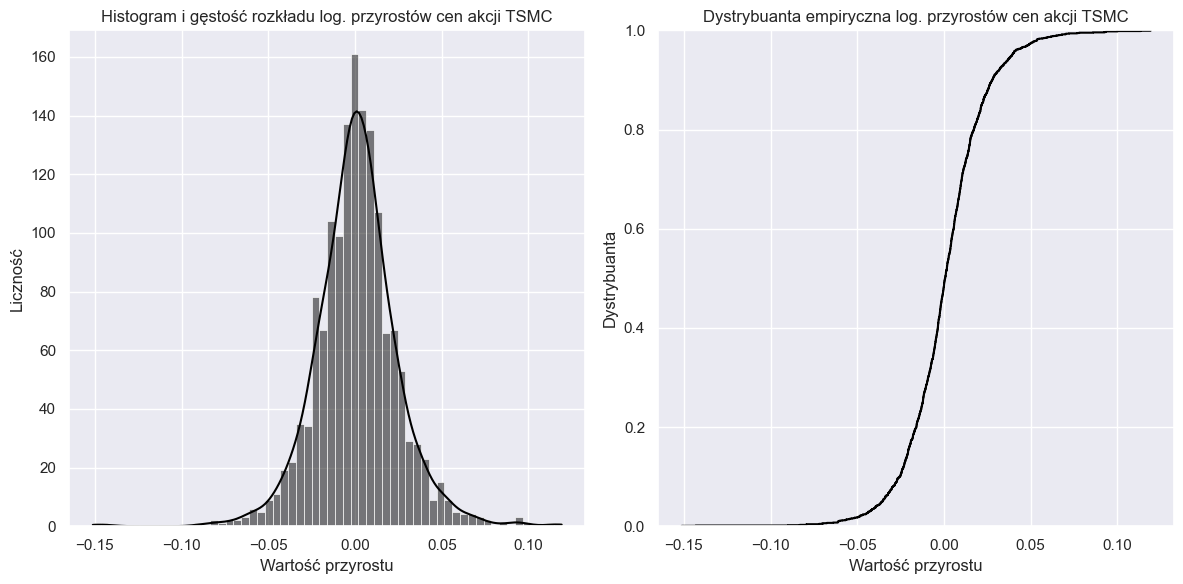

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_tsmc, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen akcji TSMC')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_tsmc, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen akcji TSMC')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()


In [18]:
normality_tests(log_returns_tsmc)

0.9658422346380113 2.1668337597247325e-18
Test Kolmogorova-Smirnova:
Statystyka: 0.0551, p-wartość: 0.0002
Wynik testu Kolmogorova-Smirnova:
Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.

Test D'Agostino i Pearson:
Statystyka: 130.9881, p-wartość: 0.0000
Wynik testu D'Agostino i Pearson:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.

Test Shapiro-Wilka:
Statystyka: 0.9658, p-wartość: 0.0000
Wynik testu Shapiro-Wilka:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.


In [19]:
t_student_tests(log_returns_tsmc)
d_f, loc, sc = st.t.fit(log_returns_tsmc)

4.460218133216609 0.0007226221555688888 0.01785164318856071
Test t-Studenta:
Statystyka t: 0.3196, p-wartość: 0.7493
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0161, p-wartość: 0.8236
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


In [20]:
d_f, loc, sc
d_f = 5

c:\Users\matio\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


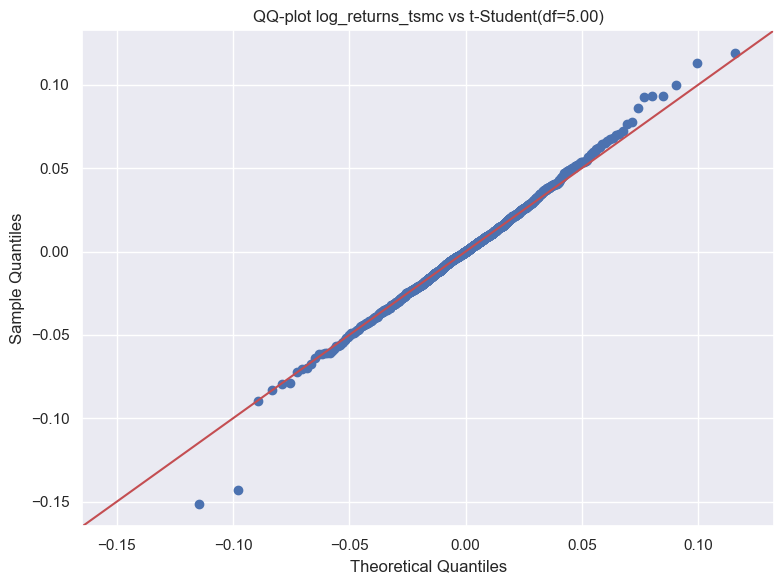

In [21]:
import statsmodels.api as sm

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sm.qqplot(log_returns_tsmc, color = 'black', dist=st.t(d_f, loc, sc), line='45', ax=ax)
plt.title(f'QQ-plot log_returns_tsmc vs t-Student(df={d_f:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

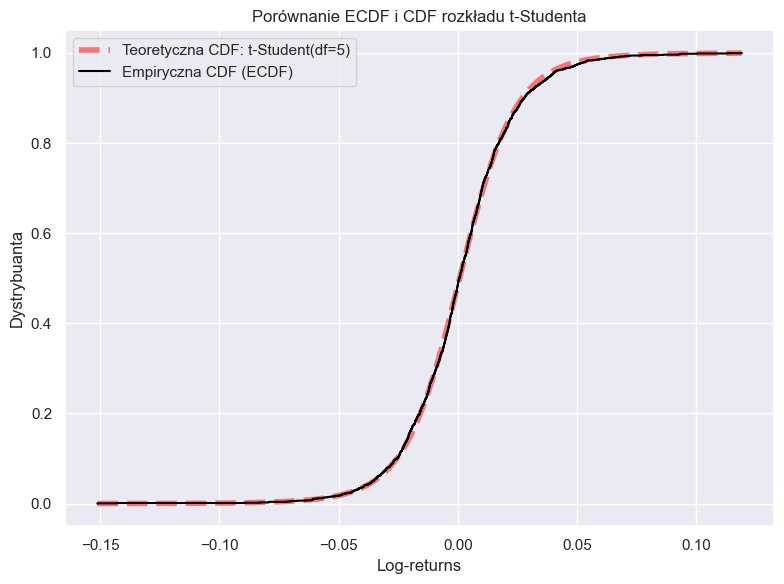

In [22]:
# Upewniamy się, że dane są 1D
log_returns_flat = np.ravel(log_returns_tsmc)

# Empiryczna dystrybuanta
ecdf = ECDF(log_returns_flat)

# Siatka do wykresu
x = np.linspace(min(log_returns_flat), max(log_returns_flat), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Log-returns')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
simulated_data = st.t.rvs(d_f, loc=loc, scale=sc, size=N)
parametry(simulated_data)

,Miara,Wartość
0,Odchylenie standardowe,0.0230
1,Odchylenie przeciętne,0.0169
2,Rozstęp międzykwartylowy,-0.0260
3,Odchylenie ćwiartkowe,0.0130
4,Semiodchylenie standardowe,0.0167
5,Semiodchylenie przeciętne,0.0085
6,Średnia,0.0007
7,Współczynnik zmienności,33.6868


## Podejście nieparametryczne

In [24]:
parametry(log_returns_tsmc)

,Miara,Wartość
0,Odchylenie standardowe,0.0238
1,Odchylenie przeciętne,0.0173
2,Rozstęp międzykwartylowy,-0.0259
3,Odchylenie ćwiartkowe,0.0129
4,Semiodchylenie standardowe,0.0174
5,Semiodchylenie przeciętne,0.0086
6,Średnia,0.0009
7,Współczynnik zmienności,25.8678


In [25]:
def kwantyle(df, title, levels_df=[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]):
    # wykres
    levels = np.arange(0.01, 1, 0.01)
    q = np.quantile(df, levels)
    sns.lineplot(x=levels, y=q, color = 'black')
    plt.title(f'Wykres kwantylowy dla {title}')
    plt.show()
    
    # tabela z wynikami
    q = np.quantile(df, levels_df)
    data = pd.DataFrame({'Kwantyl':levels_df, 'Wartość':q})
    return data

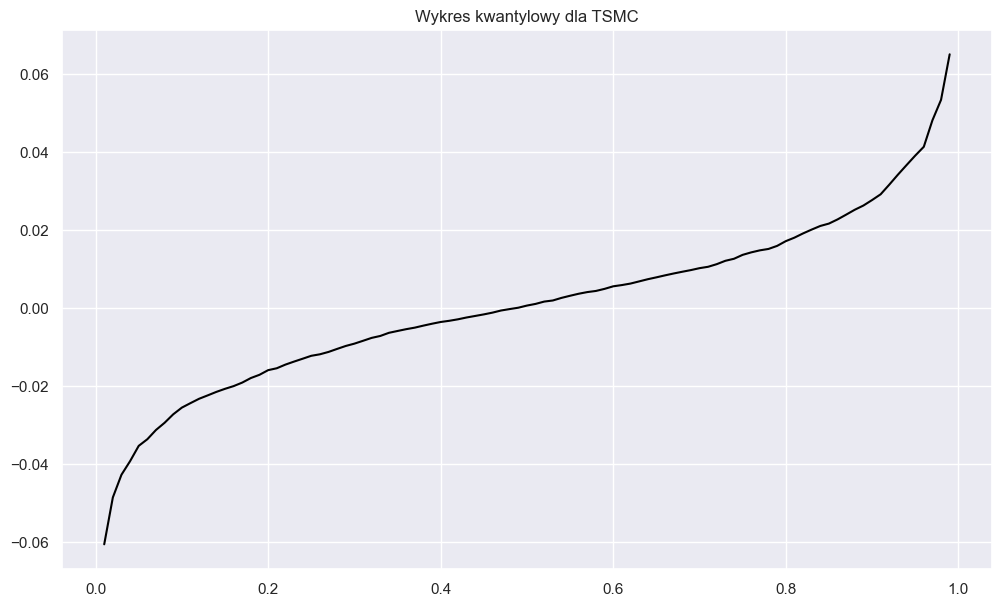

,Kwantyl,Wartość
0,0.0500,-0.0353
1,0.1500,-0.0207
2,0.2500,-0.0122
3,0.3500,-0.0059
4,0.4500,-0.0016
5,0.5500,0.0032
6,0.6500,0.0079
7,0.7500,0.0137
8,0.8500,0.0217
9,0.9500,0.0391


In [26]:
kwantyle(log_returns_tsmc, 'TSMC')

## Wartości dystrybuanty

In [27]:
def wartosc_dystrybuanty(X, wartosci=[0.01, 0.02, 0.05, 0.1, 0.15, 0.2]):
    ecdf = ECDF(X)
    data = pd.DataFrame({'Ustalona wartość':wartosci, 'wartość dystrybuanty':ecdf(wartosci)})
    return data

In [28]:
wartosc_dystrybuanty(log_returns_tsmc, [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2])

,Ustalona wartość,wartość dystrybuanty
0,0.0001,0.4901
1,0.0005,0.4987
2,0.0010,0.5066
3,0.0050,0.5922
4,0.0100,0.6950
5,0.0500,0.9735
6,0.1000,0.9980
7,0.2000,1.0000


## Podejście parametryczne

In [29]:
loc, sc = st.norm.fit(log_returns_tsmc)
loc, sc

(np.float64(0.0009181769979749186), np.float64(0.023751259250993063))

____ 
# Analiza jednowymiarowa Copper

## Podejście parametryczne


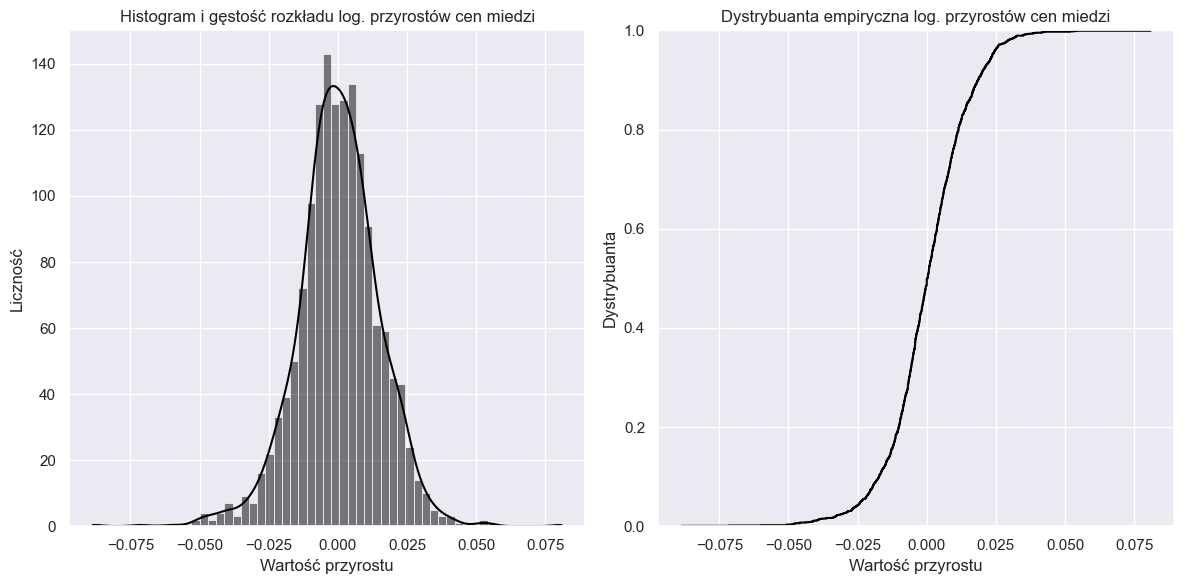

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_copper, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen miedzi')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_copper, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen miedzi')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

In [31]:
normality_tests(log_returns_copper)

0.9804956597513655 1.9216221091033214e-13
Test Kolmogorova-Smirnova:
Statystyka: 0.0441, p-wartość: 0.0055
Wynik testu Kolmogorova-Smirnova:
Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.

Test D'Agostino i Pearson:
Statystyka: 102.1669, p-wartość: 0.0000
Wynik testu D'Agostino i Pearson:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.

Test Shapiro-Wilka:
Statystyka: 0.9805, p-wartość: 0.0000
Wynik testu Shapiro-Wilka:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.


In [54]:
t_student_tests(log_returns_copper)
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

6.368984718814042 0.0004213393523033838 0.012259759699574789
Test t-Studenta:
Statystyka t: -0.4959, p-wartość: 0.6201
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0158, p-wartość: 0.8421
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


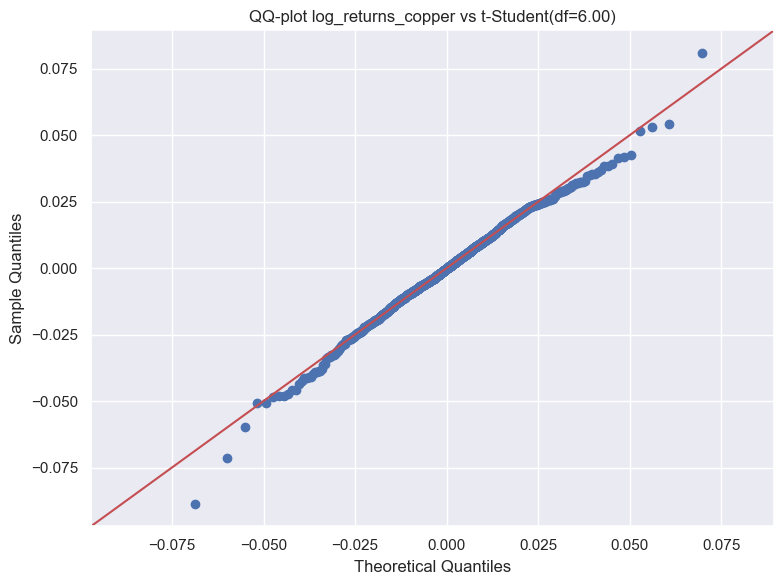

In [33]:
import statsmodels.api as sm

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sm.qqplot(log_returns_copper, dist=st.t(d_f, loc, sc), line='45', ax=ax)
plt.title(f'QQ-plot log_returns_copper vs t-Student(df={d_f:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

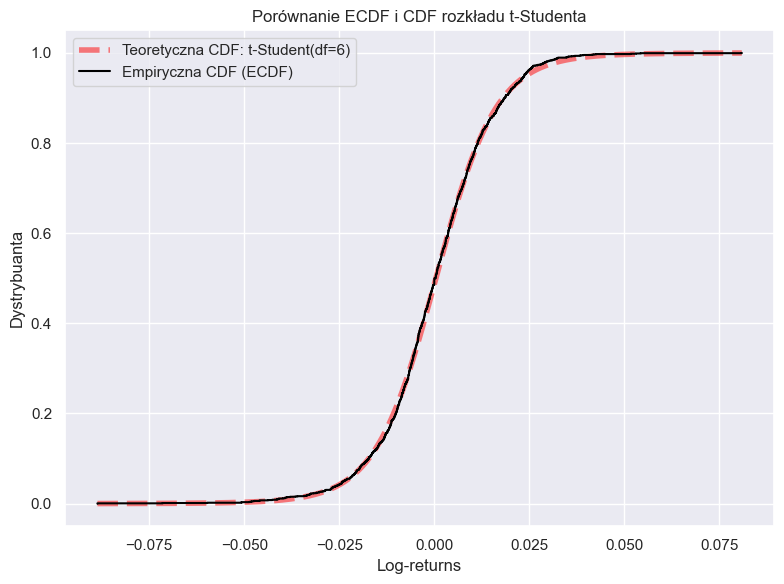

In [34]:
ecdf = ECDF(log_returns_copper)

# Siatka do wykresu
x = np.linspace(min(log_returns_copper), max(log_returns_copper), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Log-returns')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
simulated_data = st.t.rvs(d_f, loc=loc, scale=sc, size=N)
parametry(simulated_data)

,Miara,Wartość
0,Odchylenie standardowe,0.0151
1,Odchylenie przeciętne,0.0113
2,Rozstęp międzykwartylowy,-0.0176
3,Odchylenie ćwiartkowe,0.0088
4,Semiodchylenie standardowe,0.0108
5,Semiodchylenie przeciętne,0.0056
6,Średnia,0.0003
7,Współczynnik zmienności,56.9301


## Podejście nieparametryczne

In [36]:
parametry(log_returns_copper)

,Miara,Wartość
0,Odchylenie standardowe,0.0148
1,Odchylenie przeciętne,0.0112
2,Rozstęp międzykwartylowy,-0.0174
3,Odchylenie ćwiartkowe,0.0087
4,Semiodchylenie standardowe,0.0104
5,Semiodchylenie przeciętne,0.0056
6,Średnia,0.0002
7,Współczynnik zmienności,63.7925


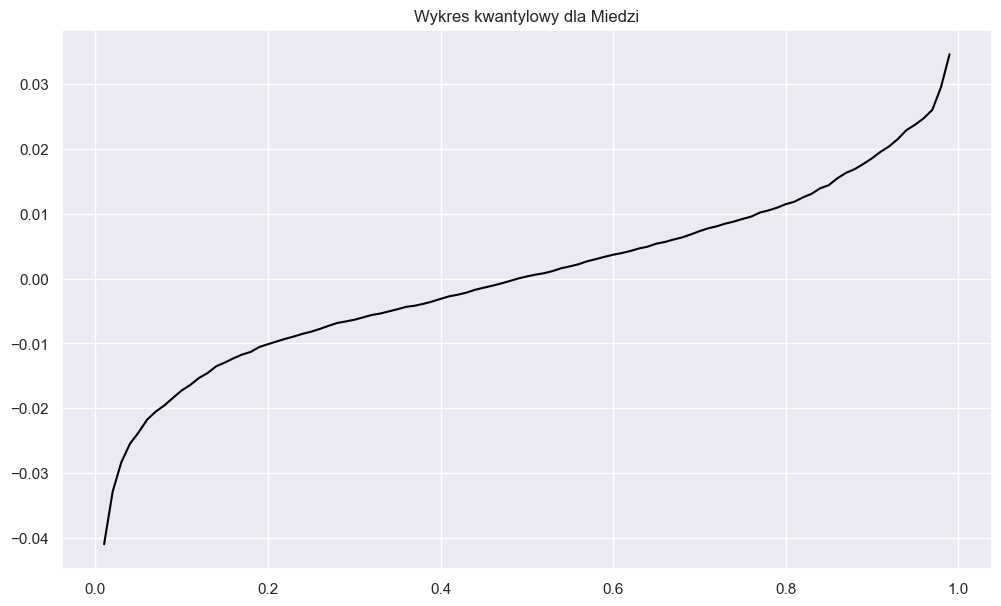

,Kwantyl,Wartość
0,0.0500,-0.0237
1,0.1500,-0.0129
2,0.2500,-0.0082
3,0.3500,-0.0047
4,0.4500,-0.0014
5,0.5500,0.0019
6,0.6500,0.0054
7,0.7500,0.0092
8,0.8500,0.0144
9,0.9500,0.0237


In [37]:
kwantyle(log_returns_copper, 'Miedzi')

In [38]:
wartosc_dystrybuanty(log_returns_copper, [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2])

,Ustalona wartość,wartość dystrybuanty
0,0.0001,0.4997
1,0.0005,0.5076
2,0.0010,0.5249
3,0.0050,0.6421
4,0.0100,0.7681
5,0.0500,0.9973
6,0.1000,1.0000
7,0.2000,1.0000


In [39]:
loc, sc = st.norm.fit(log_returns_copper)
loc, sc

(np.float64(0.00023219890233449537), np.float64(0.014812546780368753))

____ 
# Analiza jednowymiarowa SAMSUNG

## Podejście parametryczne


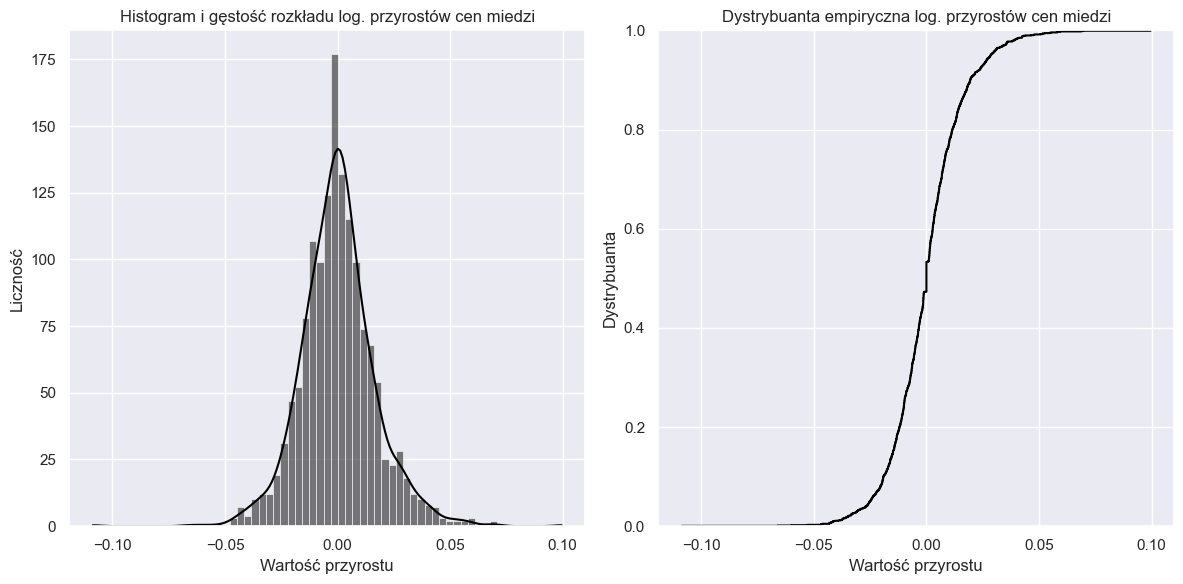

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_samsung, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen miedzi')
axes[0].set_xlabel('Wartość przyrostu')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_samsung, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen miedzi')
axes[1].set_xlabel('Wartość przyrostu')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

In [65]:
normality_tests(log_returns_samsung)

0.9713075822324948 1.52486872361261e-16
Test Kolmogorova-Smirnova:
Statystyka: 0.0588, p-wartość: 0.0001
Wynik testu Kolmogorova-Smirnova:
Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu normalnego.

Test D'Agostino i Pearson:
Statystyka: 121.4842, p-wartość: 0.0000
Wynik testu D'Agostino i Pearson:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.

Test Shapiro-Wilka:
Statystyka: 0.9713, p-wartość: 0.0000
Wynik testu Shapiro-Wilka:
Odrzucamy hipotezę zerową: dane nie są normalnie rozłożone.


In [138]:
t_student_tests(log_returns_samsung)
d_f, loc, sc = st.t.fit(log_returns_samsung)
d_f = 5

4.6898127576406985 -0.00024660566078418204 0.012764065850701178
Test t-Studenta:
Statystyka t: 1.0205, p-wartość: 0.3077
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0344, p-wartość: 0.0591
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


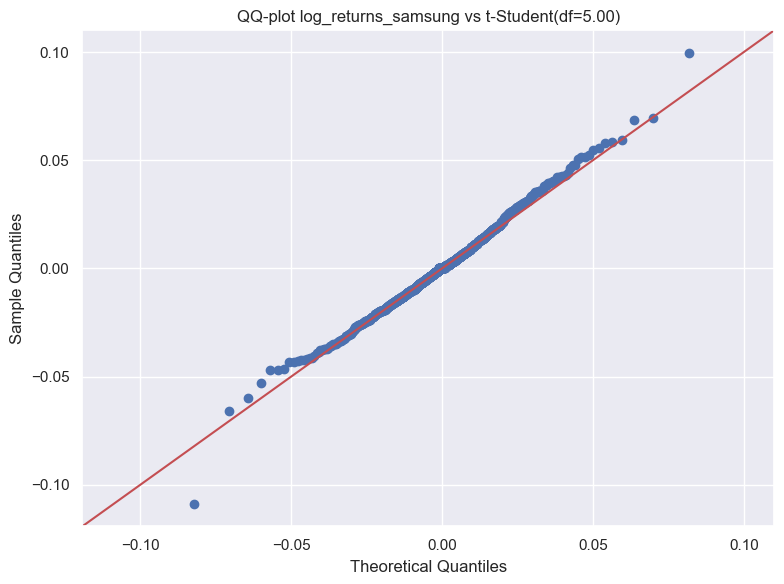

In [139]:
import statsmodels.api as sm

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sm.qqplot(log_returns_samsung, dist=st.t(d_f, loc, sc), line='45', ax=ax)
plt.title(f'QQ-plot log_returns_samsung vs t-Student(df={d_f:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()

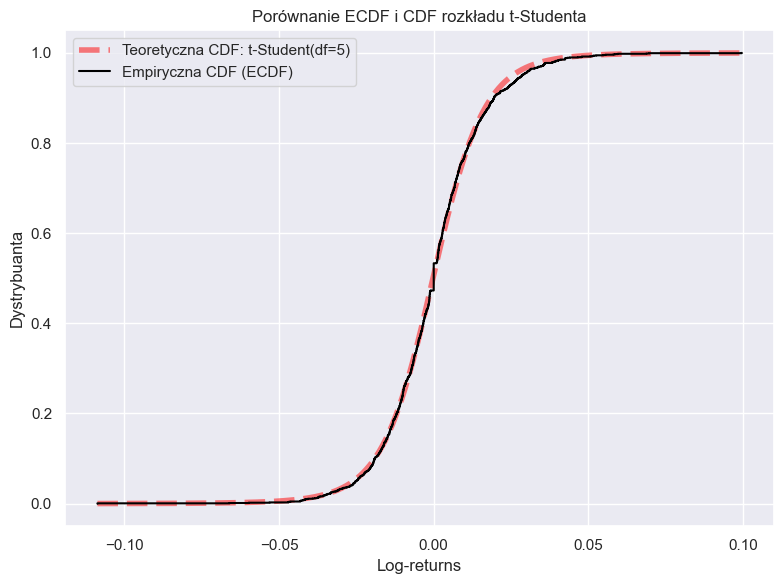

In [68]:
ecdf = ECDF(log_returns_samsung)

# Siatka do wykresu
x = np.linspace(min(log_returns_samsung), max(log_returns_samsung), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Log-returns')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [390]:
simulated_data = st.t.rvs(d_f, loc=loc, scale=sc, size=N)
parametry(simulated_data)

,Miara,Wartość
0,Odchylenie standardowe,0.0164
1,Odchylenie przeciętne,0.0121
2,Rozstęp międzykwartylowy,-0.0185
3,Odchylenie ćwiartkowe,0.0093
4,Semiodchylenie standardowe,0.0115
5,Semiodchylenie przeciętne,0.0060
6,Średnia,-0.0002
7,Współczynnik zmienności,-85.6957


## Podejście nieparametryczne

In [204]:
parametry(log_returns_samsung)

,Miara,Wartość
0,Odchylenie standardowe,0.0166
1,Odchylenie przeciętne,0.0122
2,Rozstęp międzykwartylowy,-0.0184
3,Odchylenie ćwiartkowe,0.0092
4,Semiodchylenie standardowe,0.0122
5,Semiodchylenie przeciętne,0.0061
6,Średnia,0.0002
7,Współczynnik zmienności,85.0886


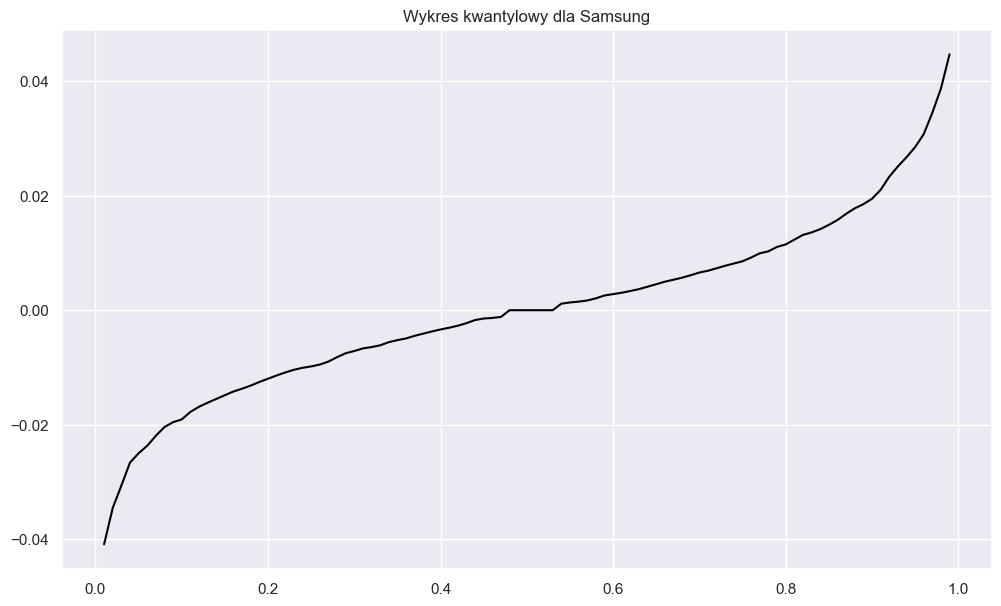

,Kwantyl,Wartość
0,0.0500,-0.0250
1,0.1500,-0.0148
2,0.2500,-0.0098
3,0.3500,-0.0052
4,0.4500,-0.0015
5,0.5500,0.0014
6,0.6500,0.0045
7,0.7500,0.0085
8,0.8500,0.0149
9,0.9500,0.0285


In [47]:
kwantyle(log_returns_samsung, 'Samsung')

In [48]:
wartosc_dystrybuanty(log_returns_samsung, [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2])

,Ustalona wartość,wartość dystrybuanty
0,0.0001,0.5332
1,0.0005,0.5332
2,0.0010,0.5346
3,0.0050,0.6615
4,0.0100,0.7720
5,0.0500,0.9919
6,0.1000,1.0000
7,0.2000,1.0000


In [49]:
loc, sc = st.norm.fit(log_returns_samsung)
loc, sc

(np.float64(0.00019533429824915774), np.float64(0.016620715999709285))